# Data Checks

Quick overview data checks and explorations for a session Treasure Hunt data.

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

# Import spike related utilities from spiketools
from spiketools.measures import compute_spike_rate
from spiketools.spatial.occupancy import compute_occupancy
from spiketools.plts.data import plot_bar, plot_hist
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.spikes import plot_unit_frs
from spiketools.plts.trials import plot_rasters
from spiketools.plts.utils import make_axes
from spiketools.utils.data import get_value_by_time, get_value_by_time_range

In [3]:
import sys
sys.path.append('../code')
from utils import convert_ms_to_minutes
from plts import plot_task_structure

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define task & subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Define bins to use
bins = [7, 21]

## Load NWB Data

In [8]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [9]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [10]:
# Check the NWBfile contents
nwbfile

root pynwb.file.NWBFile at 0x140354461344912
Fields:
  acquisition: {
    chest_positions <class 'pynwb.behavior.Position'>,
    chest_trials <class 'pynwb.behavior.Position'>,
    position <class 'pynwb.behavior.Position'>,
    recall <class 'pynwb.behavior.Position'>
  }
  data_collection: West Virginia
  devices: {
    Microwire Electrodes <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    A-microwires-chnum <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: This file contains a recorded session of the Treasure Hunt task, a spatial-navigation memory task. The subject is a clinical patient with intractable epilepsy undergoing pre-surgical mapping in an epilepsy monitoring unit, with implants including Behnke-Fried microwires.
  experimenter: ['XX']
  file_create_date: [datetime.datetime(2022, 4, 1, 17, 24, 28, 174148, tzinfo=tzoffset(None, -14400))]
  identifier: p16WV_CelebA_S3_NavFace_S3
  

## Task Structure

In the following, shadings are:
- green is encoding (navigation)
- yellow is the distractor task
- purple is recall (using the selector)

In [11]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


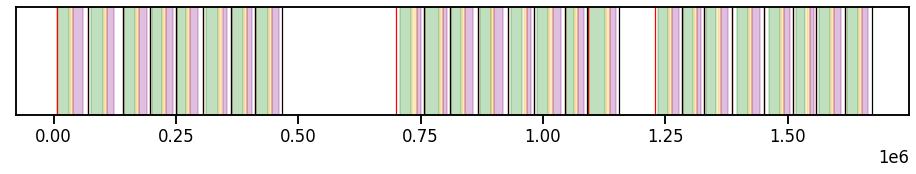

In [12]:
# Plot the task structure for the whole recording
plot_task_structure(nwbfile.trials)

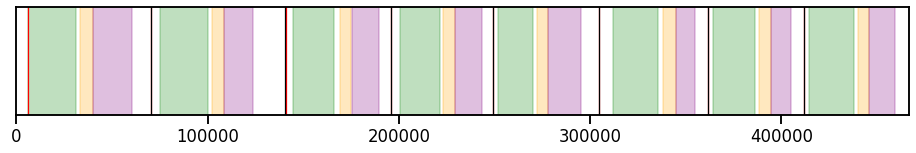

In [13]:
# Plot the task structure for a single block
plot_task_structure(nwbfile.trials, xlim=[0, nwbfile.trials.stop_time[7]])

## Position Data

In [14]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']
pos

xy_position pynwb.behavior.SpatialSeries at 0x140354461728288
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (2, 25761), type "<f8">
  description: XY position of the subject in the arena.
  interval: 1
  reference_frame: middle
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (25761,), type "<f8">
  timestamps_unit: seconds
  unit: meters

In [15]:
# Extract position timestamps and values
ptimes = pos.timestamps[:]
positions = pos.data[:]

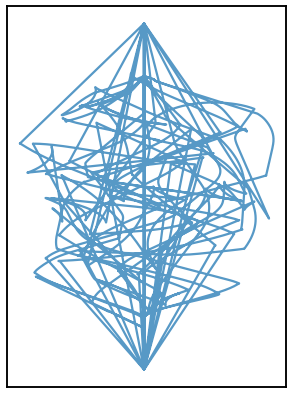

In [16]:
# Plot the map across all position traces
plot_positions(pos.data, alpha=0.75, figsize=(5, 7))

In [17]:
# Extract position data
x_data = pos.data[0, :]
y_data = pos.data[1, :]

In [18]:
# Check position ranges
print('x data range: {:6.2f} - {:6.2f}'.format(np.min(x_data), np.max(x_data)))
print('y data range: {:6.2f} - {:6.2f}'.format(np.min(y_data), np.max(y_data)))

x data range: 365.40 - 404.59
y data range: 285.00 - 433.00


In [19]:
# Get speed
speed = nwbfile.processing['position_measures']['speed'].data[:]

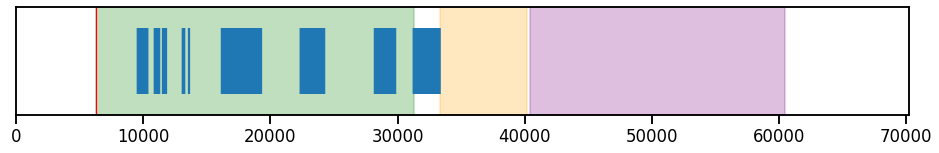

In [20]:
# Check when position times are samples across a single trial
plot_task_structure(nwbfile.trials, xlim=[0, nwbfile.trials.stop_time[0]])
trial_ptimes = get_value_by_time_range(ptimes, ptimes, 0, nwbfile.trials.stop_time[0])
plt.eventplot(trial_ptimes)

## Occupancy

In [21]:
# Compute occupancy values
occ = compute_occupancy(pos.data[:], pos.timestamps[:], bins, speed, set_nan=True)

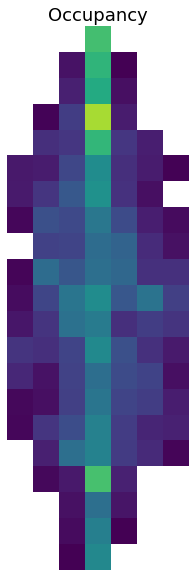

In [22]:
# Plot the occupancy
plot_heatmap(occ, transpose=True, title="Occupancy", vmax=12, figsize=(10, 10))

## Stimuli

In [23]:
# Collect chest positions
chest_pos = nwbfile.acquisition['chest_positions']
chest_xs, chest_ys = chest_pos['chest_positions'].data[:]

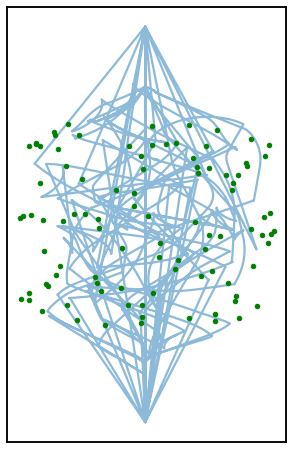

In [24]:
# Plot the subject positions, overlaid with chest positions
plot_positions(positions, alpha=0.5, figsize=(5, 8))
plt.gca().plot(chest_xs, chest_ys, '.g');

In [25]:
# Collect and check which trial each trial is in
chest_trials = nwbfile.acquisition['chest_trials']
chest_trials = chest_trials['chest_trials'].data[:]
chest_trials

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
       21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23])

### Trial-by-Trial

In the following representation:
- purple dots are the trial start location
- orange dots are the trial end location (where they do recall from)
- green dots are the chest locations

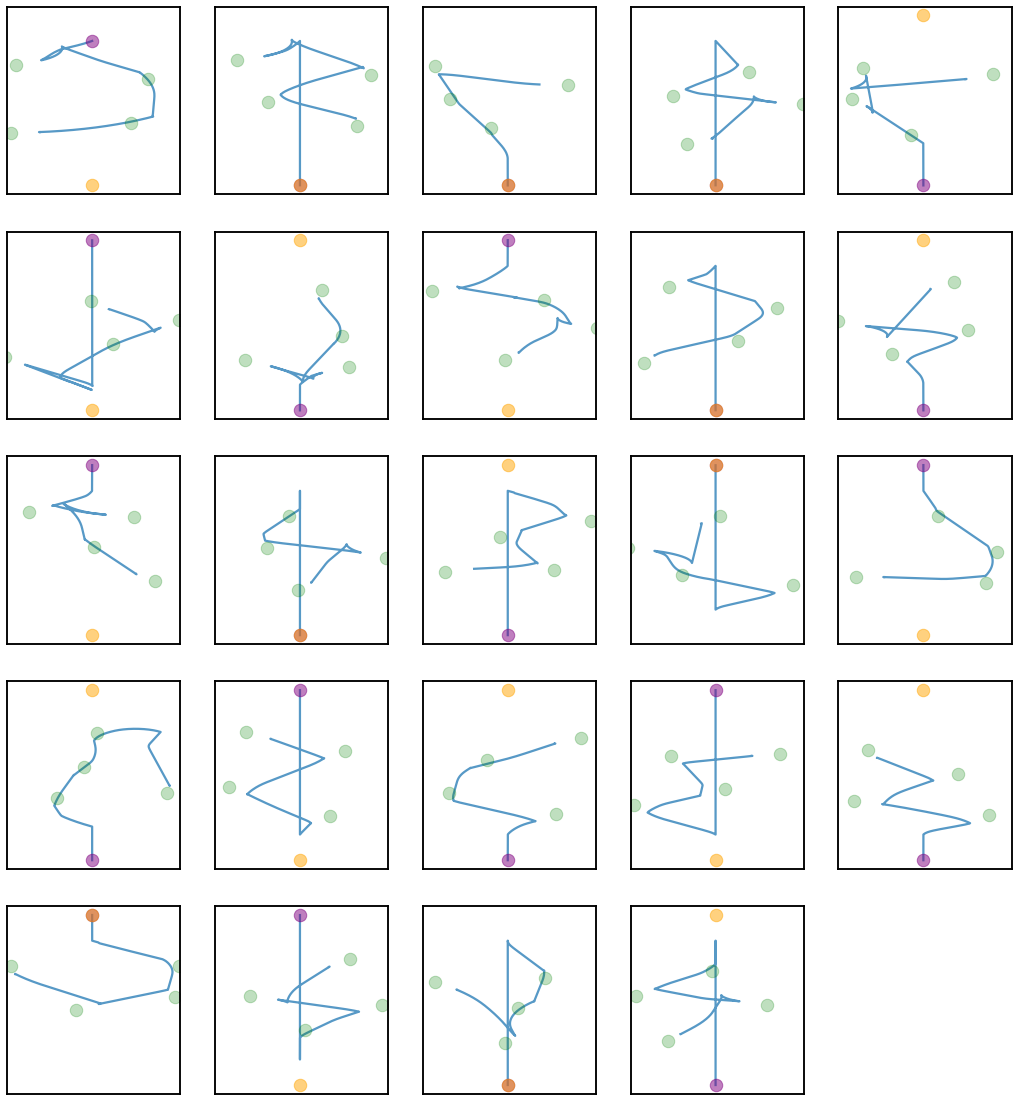

In [26]:
# Plot the trajectories for each trial
for t_ind, ax in zip(range(n_trials), make_axes(n_trials)):
    
    t_st = nwbfile.trials['start_time'][t_ind]
    ch_openings = nwbfile.trials['chest_opening'][t_ind]
    t_en = nwbfile.trials['stop_time'][t_ind]
    last_ch = ch_openings[-1]
        
    # Plot the position traces
    t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, last_ch)
    plot_positions(t_pos, alpha=0.75, ax=ax)

    # Plot the trial start & end points
    ax.plot(*t_pos[:, 0], '.', color='purple', ms=25, alpha=0.5)
    
    xx = get_value_by_time(ptimes, positions, t_en)
    ax.plot(*xx, '.', color='orange', ms=25, alpha=0.5)
    
    # Plot the chest locations
    t_mask = chest_trials == t_ind
    ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=25, alpha=0.25)
    
    # ToDo: fix setting the x & y limits to the terrain range
    ax.set_xlim((363.44401500000004, 406.546085))
    ax.set_ylim((277.6, 440.4))

### Recall Selector

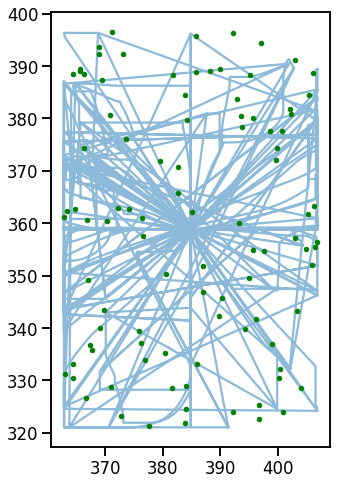

In [27]:
# Plot the positions of the recall selector, overlaid with chest positions
#   Note: update this to use plot_positions
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*nwbfile.acquisition['recall']['selector'].data[:], alpha=0.5)
ax.plot(chest_xs, chest_ys, '.g');

## Trials

In [28]:
# Check the data available in the NWB trials section
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x140354461899360
Fields:
  colnames: ['start_time' 'stop_time' 'chest_opening' 'confidence' 'correct'
 'distractor_end' 'distractor_start' 'encoding_end' 'encoding_start'
 'error' 'full_chest' 'num_chests' 'num_treasures' 'recall_end'
 'recall_start' 'response' 'stimulus']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    chest_opening_index <class 'hdmf.common.table.VectorIndex'>,
    chest_opening <class 'hdmf.common.table.VectorData'>,
    confidence_index <class 'hdmf.common.table.VectorIndex'>,
    confidence <class 'hdmf.common.table.VectorData'>,
    correct_index <class 'hdmf.common.table.VectorIndex'>,
    correct <class 'hdmf.common.table.VectorData'>,
    distractor_end <class 'hdmf.common.table.VectorData'>,
    distractor_start <class 'hdmf.common.table.VectorData'>,
    encoding_end <class 'hdmf.common.table.VectorData'>,
    encoding_start <class 'hdmf.common.

In [29]:
# Check event names
event_names = nwbfile.trials.colnames
print(event_names)

('start_time', 'stop_time', 'chest_opening', 'confidence', 'correct', 'distractor_end', 'distractor_start', 'encoding_end', 'encoding_start', 'error', 'full_chest', 'num_chests', 'num_treasures', 'recall_end', 'recall_start', 'response', 'stimulus')


In [30]:
# Check the number of trials in the dataset
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [31]:
# Get the trial information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()

,start_time,stop_time,chest_opening,confidence,correct,distractor_end,distractor_start,encoding_end,encoding_start,error,full_chest,num_chests,num_treasures,recall_end,recall_start,response,stimulus
id,,,,,,,,,,,,,,,,,
0,6244.033447,70220.378418,"[13948.0751953125, 19883.107177734375, 25451.1...","[maybe, maybe, maybe]","[False, False, False]",40177.216553,33304.179443,31305.168701,6257.033691,"[45.73503750791073, 52.22430978098226, 55.4599...","[False, True, True, True]",4,3,60458.325928,40372.217529,"[49308.265625, 54688.294677734375, 60243.32470...","[FacePlanePrefab, FacePlanePrefab, FacePlanePr..."
1,70228.378418,140762.758789,"[79475.42822265625, 86855.46801757812, 93549.5...","[maybe, maybe, maybe]","[False, False, False]",108727.585938,102554.552734,100304.540527,75247.405518,"[32.423174423396574, 34.150836314796145, 36.51...","[True, True, False, True]",4,3,124001.668457,108796.586426,"[117099.63110351562, 120939.65185546875, 12374...","[FacePlanePrefab, FacePlanePrefab, FacePlanePr..."
2,140769.758789,195939.056152,"[151468.81640625, 155523.83837890625, 159508.8...","[maybe, maybe]","[False, False]",175186.944336,169062.911377,166173.895752,144580.779297,"[14.604033802343807, 15.834481971318136]","[True, True, False, False]",4,2,189858.023438,175331.945068,"[182588.98413085938, 189621.02221679688]","[FacePlanePrefab, FacePlanePrefab]"
3,195946.056152,249401.344482,"[203875.09887695312, 208312.12280273438, 21321...","[maybe, maybe]","[True, False]",229218.235596,223121.202637,221275.192871,200849.082764,"[3.516259944884664, 22.22750061815316]","[False, True, True, False]",4,2,243451.312256,229294.236084,"[235904.27172851562, 243111.310546875]","[FacePlanePrefab, FacePlanePrefab]"
4,249408.344482,304697.642578,"[255448.376953125, 259289.39770507812, 263246....","[maybe, maybe, maybe]","[True, True, True]",277848.497803,272362.468262,270181.456543,251970.358154,"[10.951025670684906, 8.672983876383018, 6.6770...","[False, True, True, True]",4,3,295344.592041,277931.498291,"[287429.54931640625, 291060.5690917969, 295100...","[FacePlanePrefab, FacePlanePrefab, FacePlanePr..."


#### Confidence

In [32]:
# Count confidence answers
conf_counts = Counter(nwbfile.trials.confidence.data[:])

In [33]:
# Fix confidence answers
for el in ['yes', 'maybe', 'no']:
    if el not in conf_counts:
        conf_counts[el] = 0

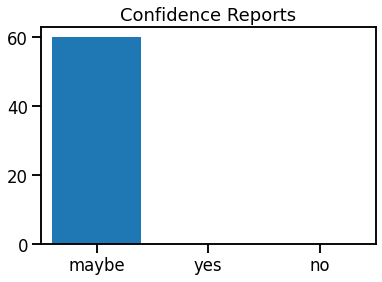

In [34]:
# Plot confidence answers
plot_bar(conf_counts.values(), conf_counts.keys(), title='Confidence Reports')

#### Response Error

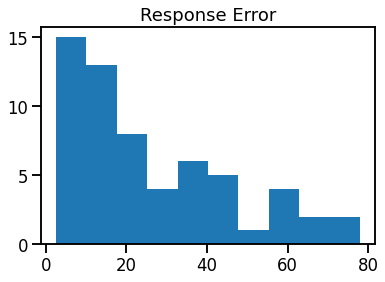

In [35]:
# Plot response error
plot_hist(nwbfile.trials.error.data[:], title='Response Error')

## Check Unit Data

Note that we only look at units that are marked to keep.

In [36]:
# Check the data available in the NWB units section
nwbfile.units

units pynwb.misc.Units at 0x140354461900656
Fields:
  colnames: ['channel' 'cluster' 'keep' 'location' 'wvID' 'spike_times' 'electrodes']
  columns: (
    channel <class 'hdmf.common.table.VectorData'>,
    cluster <class 'hdmf.common.table.VectorData'>,
    keep <class 'hdmf.common.table.VectorData'>,
    location <class 'hdmf.common.table.VectorData'>,
    wvID <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  )
  description: Spike sorting solutions - done with oSort by Runnan Cao.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [37]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 81


In [38]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 311316


In [39]:
# Count the number of units per wire
channel_counts = Counter(nwbfile.units.channel[:])
counts_per_wire = Counter(channel_counts.values())

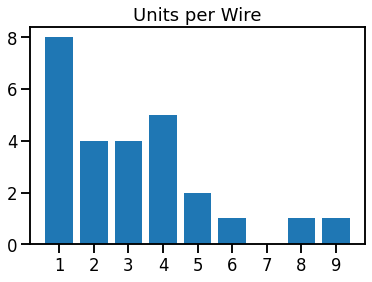

In [40]:
# Plot the distribution of units per wire
plt.bar(counts_per_wire.keys(), counts_per_wire.values())
plt.xticks(list(range(min(counts_per_wire.keys()), max(counts_per_wire.keys()) + 1)));
plt.title('Units per Wire');

#### Check Keep & Reject Neurons

In [41]:
# Check how many units are marked to keep
n_keep = sum(nwbfile.units.keep[:])
print('Number of keep neurons: {}'.format(n_keep))

Number of keep neurons: 57


In [42]:
# Get the indices of the neurons to keep
keep_inds = np.where(nwbfile.units.keep[:])[0]
assert len(keep_inds) == n_keep

In [43]:
# Get the indices of the neurons that are rejected
reject_inds = np.where((nwbfile.units.keep[:] - 1) * -1)[0]
assert len(reject_inds) + n_keep == n_units

In [44]:
# Calculate the average overall firing rate of each neuron
rates = [compute_spike_rate(nwbfile.units.get_unit_spike_times(s_ind) / 1000) \
         for s_ind in keep_inds]

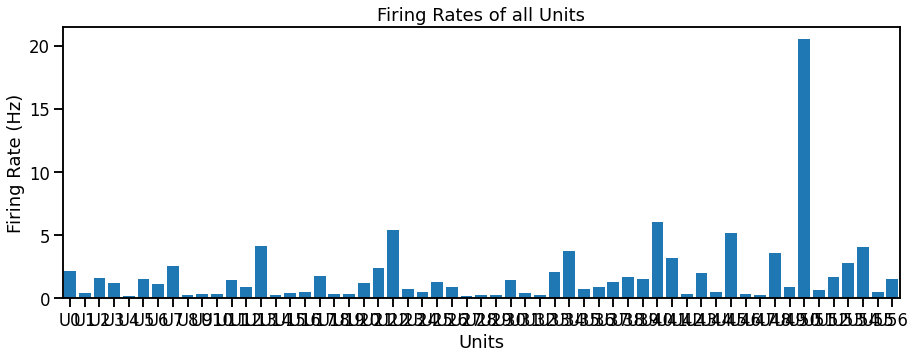

In [45]:
# Plot approximate firing rate for each unit
plot_unit_frs(rates, figsize=(15, 5))

In [46]:
# Collect session normalized spiking activity across all units
all_spikes = []
for uind in keep_inds:
    all_spikes.append(nwbfile.units.get_unit_spike_times(uind))

In [47]:
# Set start and stop time of the task (note that 0 is task start time)
st = 0
en = nwbfile.trials.stop_time[-1]

In [48]:
# Compute the task length, in minutes
task_len = convert_ms_to_minutes(en)

In [49]:
# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))

Task length: 27.87 minutes


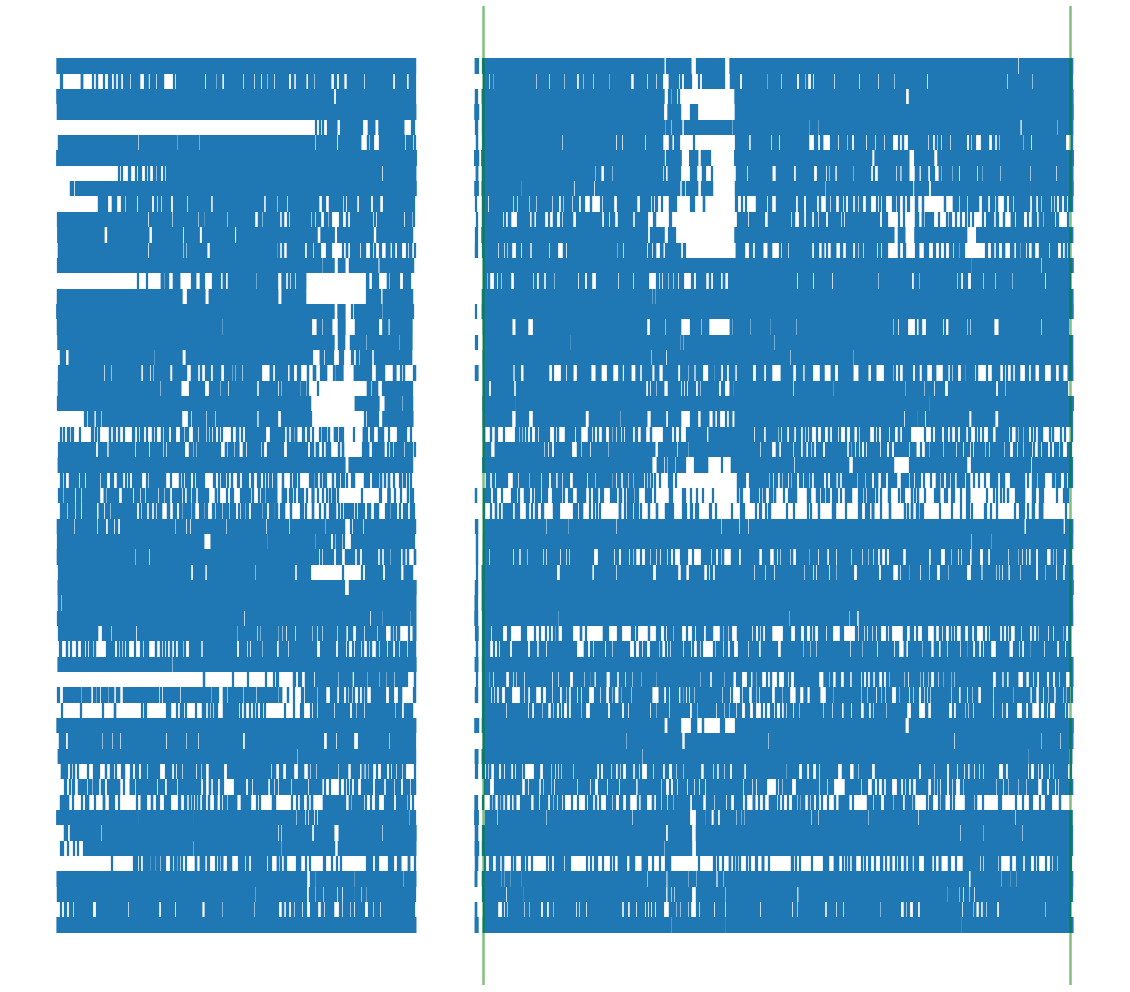

In [50]:
# Plot the session-level raster plot across all units together
plot_rasters(all_spikes, vline=[st, en], figsize=(20, 18))

In [51]:
# # Print out the whole-session spike raster for each neuron separately
# for uind in keep_inds:
#     spikes = nwbfile.units.get_unit_spike_times(uind)
#     plot_rasters(spikes, show_axis=True, figsize=(16, 2))